In [1]:
# Decided to try another library written in Rust instead of Pandas (maybe that was a mistake)
import polars as pl  
from polars.lazy import col

# This gets first entry from column A filtered by value of column B
# Probably there exists a better way
def get_first_entry_with_filter(df, result_col, filter_col, value):
    filtered = df.lazy().filter(col(filter_col) == value).collect()
    
    count = filtered.lazy().select([pl.count('*')]).collect()[0][0]
    if count == 0:
        return 0
    return filtered[result_col][0]


df = pl.read_csv("record_updates_vpn_no_pull.csv")
# getting the records which appeared first
records_first = (
    df.sort(by_column='Timestamp')
    .groupby('RecordId')
    .agg([col("Type").first()])
    .groupby('Type_first')
    .agg([col('RecordId').count()])
)
records_first
first_push = get_first_entry_with_filter(records_first, 'RecordId_count', 'Type_first', 1)
first_pubsub = get_first_entry_with_filter(records_first, 'RecordId_count', 'Type_first', 2)
first_getrecords = get_first_entry_with_filter(records_first, 'RecordId_count', 'Type_first', 4)

In [2]:
import numpy as np
# calculating timestamp difference
records_diff_push_pubsub = (
    df.sort(by_column='Timestamp')
    .lazy()
    .filter(col('Type') != 4)
    .collect()
    .groupby('RecordId')
    .agg([col("Type").first(), col("Type").last(), (col("Timestamp").last() - col("Timestamp").first()) / 1000])
)
sorted_diff_ms = np.array(records_diff_push_pubsub['Timestamp_last'].sort())

In [3]:
# getting which records received by which method
records_by_type = (
    df.groupby(['RecordId', 'Type'])
    .agg([col("Type").first()])
    .groupby('RecordId')
    .agg([col("Type").sum()])
    .groupby('Type_sum')
    .agg([col('RecordId').count()])
)
only_push = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 1)
only_pubsub = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 2)
both_pubsub_push = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 3)
only_getrecords = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 4)
records_by_type

Type_sum,RecordId_count
i64,u32
3,829
2,35


In [4]:
# calculating duplicated entries
records_duplication = (
    df.groupby(['RecordId', 'Type'])
    .agg([col("Type").count()])
    .groupby(['Type_count', 'Type'])
    # getting table with type and how many times we have duplication by 2, 3 etc
    .agg([col('Type_count').count().alias('Duplicated_count')])
    .lazy()
    .filter(col('Type_count') >= 2)
    .collect()
    .groupby('Type')
    # summing up different duplications
    .agg([col('Duplicated_count').sum().alias('Duplicated_count')])
) 
records_duplication
push_dup = get_first_entry_with_filter(records_duplication, 'Duplicated_count', 'Type', 1)
pubsub_dup = get_first_entry_with_filter(records_duplication, 'Duplicated_count', 'Type', 2)
getrecords_dup = get_first_entry_with_filter(records_duplication, 'Duplicated_count', 'Type', 4)

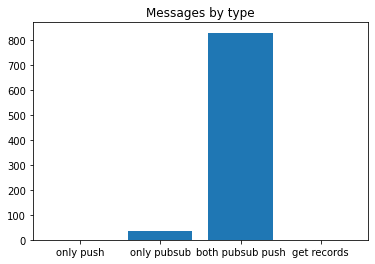

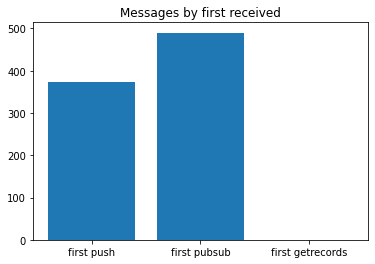

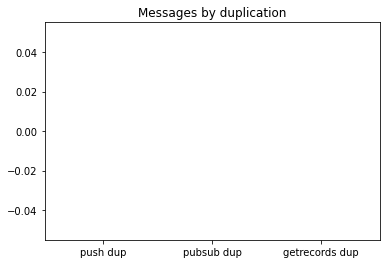

In [5]:
import matplotlib.pyplot as plt

def draw_hist(labels, values, title):
    plt.title(title)
    plt.bar(labels, values, align='center')
    plt.show()
    
draw_hist(["only push", "only pubsub", "both pubsub push", "get records"], [only_push, only_pubsub, both_pubsub_push, only_getrecords], 'Messages by type')
draw_hist(["first push", "first pubsub", "first getrecords"], [first_push, first_pubsub, first_getrecords], 'Messages by first received')
draw_hist(["push dup", "pubsub dup", "getrecords dup"], [push_dup, pubsub_dup, getrecords_dup], 'Messages by duplication')

(array([670.,  30.,  21.,  15.,  15.,  15.,   8.,   6.,   7.,   7.,  13.,
          6.,   7.,   5.,   2.,   6.,   5.,   4.,   1.,   2.,   1.,   1.,
          0.,   1.,   4.,   1.,   1.,   0.,   2.,   0.,   1.,   1.,   0.,
          0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([   0.  ,  187.58,  375.16,  562.74,  750.32,  937.9 , 1125.48,
        1313.06, 1500.64, 1688.22, 1875.8 , 2063.38, 2250.96, 2438.54,
        2626.12, 2813.7 , 3001.28, 3188.86, 3376.44, 3564.02, 3751.6 ,
        3939.18, 4126.76, 4314.34, 4501.92, 4689.5 , 4877.08, 5064.66,
        5252.24, 5439.82, 5627.4 , 5814.98, 6002.56, 6190.14, 6377.72,
        6565.3 , 6752.88, 6940.46, 7128.04, 7315.62, 7503.2 , 7690.78,
        7878.36, 8065.94, 8253.52, 8441.1 , 8628.68, 8816.26, 9003.84,
        9191.42, 9379.  ]),
 <BarContainer object of 50 artists>)

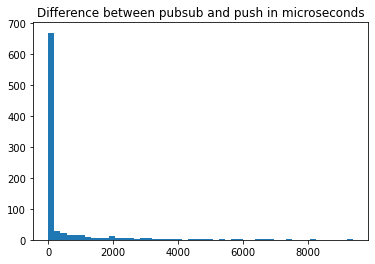

In [6]:
plt.title('Difference between pubsub and push in microseconds')
plt.hist(sorted_diff_ms, bins = 50)